In [1]:
from scipy.io import mmread
import pandas as pd
import numpy as np

np.random.seed(42)

In [2]:
df = pd.DataFrame(mmread('data/E-MTAB-10290.aggregated_filtered_normalised_counts.mtx').todense())

# read the gene names from file and add them as row names
with open('data/E-MTAB-10290.aggregated_filtered_normalised_counts.mtx_rows') as f:
    gene_names = [i.split()[0] for i in f.read().splitlines()]
df.index = gene_names

# read the cell names from file and add them as column names
with open('data/E-MTAB-10290.aggregated_filtered_normalised_counts.mtx_cols') as f:
    cell_names = f.read().splitlines()
df.columns = cell_names

# transpose the dataframe so that the genes are the columns and the cells are the rows
df = df.transpose()
df
# import the experimental design from tsv file
design = pd.read_csv('data/ExpDesign-E-MTAB-10290.tsv', sep='\t')

# keep only the columns we need
design = design[['Assay', 'Sample Characteristic[disease]']]
design.columns = ['cell', 'disease']

design.set_index('cell', inplace=True)

design = np.ndarray.flatten(design.values)
design

array(['normal', 'normal', 'normal', ..., 'cutaneous melanoma',
       'cutaneous melanoma', 'cutaneous melanoma'], dtype=object)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import f1_score

# set the seed for reproducibility
torch.manual_seed(42)
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# encode the target labels into integers
le = LabelEncoder()
design = le.fit_transform(design.ravel())

le.classes_

array(['cutaneous melanoma', 'normal'], dtype=object)

In [7]:
# define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25511, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
# define the optimizer and the loss
criterion = nn.CrossEntropyLoss()

def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# define the training function
def train(model, train_dl, optimizer, criterion):
    model.train()
    running_loss = 0
    for i, (X_batch, y_batch) in enumerate(train_dl):
        #if i % 100 == 0:
            #print(i)
        optimizer.zero_grad()
        y_pred = model(X_batch.to(device))
        loss = criterion(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dl)
    return model, train_loss

# define the testing function
def val(model, test_dl, criterion):
    model.eval()
    running_loss = 0
    correct, total = 0, 0
    predictions, truth = [], []
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_dl):
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            running_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            predictions.extend(predicted.cpu().numpy())
            truth.extend(y_batch.cpu().numpy())
            total += y_batch.size(0)
            correct += (predicted == y_batch.to(device)).sum().item()
    val_loss = running_loss / len(test_dl)
    return val_loss, f1_score(y_batch.cpu().numpy(), predicted.cpu().numpy()), predictions, truth

In [9]:
# do cv and test split
X_train, X_test, y_train, y_test = train_test_split(df, design, test_size=0.3, random_state=42, stratify=design)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20442, 25511) (8761, 25511) (20442,) (8761,)


In [10]:
# train by 5-fold cross-validation for 5 epochs
from sklearn.model_selection import StratifiedKFold

k_folds = 3
num_epochs = 2
  
# For fold results
results = {}
  
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(X_train, y_train.ravel())):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define the datsets
    dataset = data_utils.TensorDataset(torch.tensor(X_train.values.astype(np.float32)), torch.tensor(y_train.ravel()))

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=test_subsampler)

    # Init the neural network
    model = Net()
    model.to(device)
    model.apply(reset_weights)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses, val_f1s = [], [], []

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        model, train_loss = train(model, trainloader, optimizer, criterion)
        val_loss, val_f1, _, _ = val(model, testloader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1s.append(val_f1)
        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val F1: {val_f1:.2f} |')

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    # Evaluation for this fold
    y_true_final, y_pred_final = [], []
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, (X_batch, y_batch) in enumerate(testloader):

            # Generate outputs
            outputs = model(X_batch.to(device))

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            y_true_final.extend(y_batch.cpu().numpy())
            y_pred_final.extend(predicted.cpu().numpy())

    f1_final = f1_score(y_true_final, y_pred_final)

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * f1_final))
    print('--------------------------------')
    results[fold] = 100.0 * f1_final
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25511, out_features=5000, bias=True)
Reset trainable parameters of layer = Linear(in_features=5000, out_features=1000, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=2, bias=True)
Starting epoch 1
| Epoch: 01 | Train Loss: 0.595 | Val Loss: 0.249 | Val F1: 1.00 |
Starting epoch 2
| Epoch: 02 | Train Loss: 0.066 | Val Loss: 0.004 | Val F1: 1.00 |
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 99 %
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25511, out_features=5000, bias=True)
Reset trainable parameters of layer = Linear(in_features=5000, out_features=1000, bias=True)
Reset trainable parameters of layer

/home/debian/miniconda3/envs/MVI_Vojta2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


| Epoch: 01 | Train Loss: 0.512 | Val Loss: 0.199 | Val F1: 0.00 |
Starting epoch 2
| Epoch: 02 | Train Loss: 0.080 | Val Loss: 0.051 | Val F1: 1.00 |
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 1: 99 %
--------------------------------
FOLD 2
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25511, out_features=5000, bias=True)
Reset trainable parameters of layer = Linear(in_features=5000, out_features=1000, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=2, bias=True)
Starting epoch 1
| Epoch: 01 | Train Loss: 0.715 | Val Loss: 0.388 | Val F1: 1.00 |
Starting epoch 2
| Epoch: 02 | Train Loss: 0.130 | Val Loss: 0.022 | Val F1: 1.00 |
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 99 %
--------------------------------
K-FOLD CROSS VA

F1 of the network on the test set: 99 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3683
           1       1.00      1.00      1.00      5078

    accuracy                           1.00      8761
   macro avg       1.00      1.00      1.00      8761
weighted avg       1.00      1.00      1.00      8761

[[3671   12]
 [   5 5073]]


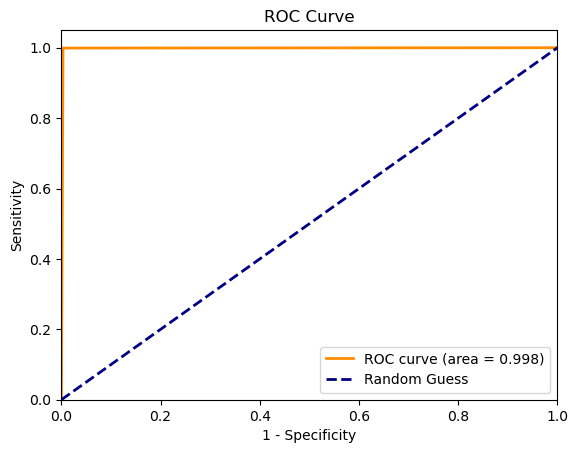

In [15]:
# predict on the test set
model = Net()
model.to(device)
model.load_state_dict(torch.load('model-fold-0.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test.values.astype(np.float32)).to(device))
    _, predicted = torch.max(y_pred.data, 1)
    print('F1 of the network on the test set: %d %%' % (100 * f1_score(y_test, predicted.cpu().numpy())))
    print(classification_report(y_test, predicted.cpu().numpy()))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, predicted.cpu().numpy())
    print(cnf_matrix)

# plot roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicted.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()